<a href="https://colab.research.google.com/github/pfolaa/fraud_detection/blob/main/fraud_detection_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import glob2
import tqdm
import json
import pandas as pd


In [3]:
cd /content/drive/MyDrive/datasets/

/content/drive/MyDrive/datasets


In [4]:
def read_json_insert_csv(root_path, json_file, file_csv):
  data = json.load(json_file)
  df = pd.DataFrame.from_records(data)
  # convert file to csv
  df.to_csv(f'{root_path}/{file_csv}', 
            sep='|', 
            index= None)

  # return 1 fichier csv fer json file
  return df 

In [5]:
def process_json( path_file_json="./nirra-log-bot", dest_path="./liberta_leasing"):
  # créer toute l'aborescence du fichier, crée le chemin
  os.makedirs(dest_path, exist_ok=True) 
  # read all json files

  json_files = glob2.glob(os.path.join(path_file_json,'*.json'))
  for file_name in tqdm.tqdm(json_files):
    with open(file_name) as json_file:
      path_file_csv = file_name.replace(".json", ".csv").split("/")[-1]
      read_json_insert_csv(dest_path, json_file, path_file_csv)

In [6]:
process_json('./nirra-log-bot', './liberta_leasing')

100%|██████████| 171/171 [02:17<00:00,  1.24it/s]


In [7]:
cd /content/drive/MyDrive/datasets/liberta_leasing/

/content/drive/MyDrive/datasets/liberta_leasing


In [8]:
import pandas as pd
import os
import glob
from tqdm import tqdm
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np


# use glob to get all the csv files 
# in the folder
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
all_df_list = [] # list of all dataframe
for f in tqdm(csv_files):    
    # read the csv file
    #col_names = ["type", "subtype", "text", "ts", "bot_id"]
    df=pd.read_csv(f, sep="|")
    all_df_list.append(df) 

100%|██████████| 171/171 [00:00<00:00, 195.27it/s]


In [9]:
print(len(all_df_list))

171


In [10]:
all_df_list[0][all_df_list[0]['type']== 'type']

,type,subtype,text,ts,bot_id


### Concatener tous les dataframe en un seul

In [11]:
df_raw = pd.concat(all_df_list, ignore_index=True)

In [12]:
df_raw.to_csv('/content/drive/MyDrive/datasets/nirra_log_bot.csv', index=None, sep='|')

In [13]:
df_temp = pd.read_csv('/content/drive/MyDrive/datasets/nirra_log_bot.csv', sep='|')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_temp.info()

In [15]:
def parse_wallet_sms_payload_success(text_type_request):
  ''' la fonction permet de parser les types de requete "Okra WebHook", "Wallet success", 
      "SMS Success" et SMS Payload en object json.
      Elle prend en paramètre le text contenu dans le type de requete,
      elle retourne un objet de type JSON.'''

  pattern = regex.compile(r'\{(?:[^{}]|(?R))*}')
  resul_patt = pattern.findall(text_type_request)
  res = resul_patt[0].replace("\\", " ")
  s = json.loads(res)
  out_dict = {} # dictionnary vide
  for key, value in s.items():
    out_dict[key.strip()] = value # à la clé on passe chaque valeur, strip() enlève les espaces au début et à la fin.


  out_dump = json.dumps(out_dict) # input est un dictionnaire et ça retourne un json sous forme string
  out_wallet_success = json.loads(out_dump) # convertir le string json en object json.
  return out_wallet_success


In [16]:
def parse_providus_transfer_error_function(text_type_request):
  pattern = regex.compile(r'\{(?:[^{}]|(?R))*}')
  resul_patt = pattern.findall(text_type_request)
  if len(resul_patt) != 0:
    res = resul_patt[0].replace("\\", " ")
    s = json.loads(res)
    out_dict = {} # dictionnary vide
    for key, value in s.items():
      out_dict[key.strip()] = value # à la clé on passe chaque valeur, strip() enlève les espaces au début et à la fin.
    out_dump = json.dumps(out_dict) # input est un dictionnaire et ça retourne un json sous forme string
    out_wallet_success = json.loads(out_dump) # convertir le string json en object json.
    return out_wallet_success
  else:
    resultat = 'Transfer to virtual account is not allowed!'
    return resultat


In [17]:
import re

# la fonction doit prendre en paramètre quelque chose
def parse_and_concatenate_Leadway_Success_Rows(df_raw):
  '''Cette fonction permet de parser et de concatener le texte qui a LEADWAY SUCCESS
     comme type de requete
     elle prend comme paramètre un dataframe et retourne les valeurs suivantes:
     - un texte concatené
     - l'index de la 1ère ligne qu'on va utiliser ensuite pour l'effacer
     - l'index de la dernière ligne qu'on va utiliser ensuite pour l'effacer '''

  first_index = 0
  last_index = 0
  text_leadway_concat = ''
  for index, row in df_raw.iterrows():  # boucler sur les colonnes de type text
      text_row = row['text']  
      if re.search('LEADWAY SUCCESS', text_row):
        text_leadway_concat = text_row
        first_index = index
        first_index +=1
        new_df = df_raw[first_index:]
        for first_index, new_row in new_df.iterrows():
          xxx = new_row['text']      
          if not xxx.startswith('['):          
            first_index += 1
            text_leadway_concat = text_row + xxx       
          elif xxx.startswith('['):
            last_index = first_index-1
            break


  return text_leadway_concat, first_index, last_index


In [18]:

# use this function when type request is LEADWAY SUCCESS
import regex
import json


def parse_Leadway_Success_Row(text_leadway):
  ''' fonction permettant de parser le text concatené pour le type de requet LEADWAY SUCCESS
      elle retourner un dictionnaire.'''
  pattern = regex.compile(r'\{(?:[^{}]|(?R))*}')
  resul_patt = pattern.findall(text_leadway)
  resul_patt[0] = resul_patt[0].replace("\\", "")
  x = resul_patt[0].replace("make,", "")
  y = x.replace('""makeName"', '"makeName"')
  z = json.loads(y)
  vehicleMake = z.get('vehicleMake')
  leadway_dict = {}
  for element in vehicleMake:
    leadway_dict[element['id']] = element['makeName']

  return leadway_dict

In [22]:
import regex
import json

def parse_Error_Row(error_row):
  error_row = error_row.replace('"', "'")
  pattern = regex.compile(r"{?[a-z :A-Z 0-9\\,=_`']+selfie")
  resul_patt = pattern.findall(error_row)
  res = resul_patt[0].replace("\\", " ")
  res = res.replace("'name'", "name").replace("`", "").replace("'18'", "18").replace("'monthly'", "monthly")
  res = res+'"}'
  res = res.replace("'", '"')
  s = json.loads(res)
  out_error_dict = {} # dictionnary vide
  for key, value in s.items():
    out_error_dict[key.strip()] = value # à la clé on passe chaque valeur, strip() enlève les espaces au début et à la fin.

  out_error_dump = json.dumps(out_error_dict) # input est un dictionnaire et ça retourne un json sous forme string
  out_error_text = json.loads(out_error_dump) # convertir le string json en object json.
  return out_error_text


In [19]:
import regex
import json

def parse_Error_Row_selfie_Function(error_row):
  error_row = error_row.replace('"', "'")
  pattern = regex.compile(r"({?[a-z :A-Z 0-9\\,=_`']+)selfie")
  resul_patt = pattern.findall(error_row)
  # checker si la liste contient au moins un element
  if len(resul_patt) !=0 :
    res = resul_patt[0].replace("\\", " ")
    res = res+'"}'
    res = res.replace("'monthly'", "monthly").replace("'", '"').replace('""', '"').replace('"monthly ", "', '"monthly"')
    s = json.loads(res)
    out_error_dict = {} # dictionnary vide
    for key, value in s.items():
      out_error_dict[key.strip()] = value # à la clé on passe chaque valeur, strip() enlève les espaces au début et à la fin.
    out_error_dump = json.dumps(out_error_dict) # input est un dictionnaire et ça retourne un json sous forme string
    out_error_text = json.loads(out_error_dump)
    out_error_text
    return out_error_text
  #si la liste est vide, on la retourne
  else:
    return resul_patt

In [24]:
df_raw['text'][26265].replace('"', "'")

"[info] - ['[VTPASS SUCCESS]:','{\\'code\\':\\'000\\',\\'content\\':{\\'transactions\\':{\\'status\\':\\'delivered\\',\\'product_name\\':\\'MTN Airtime VTU\\',\\'unique_element\\':\\'08137772005\\',\\'unit_price\\':200,\\'quantity\\':1,\\'service_verification\\':null,\\'channel\\':\\'api\\',\\'commission\\':6,\\'total_amount\\':194,\\'discount\\':null,\\'type\\':\\'Airtime Recharge\\',\\'email\\':\\'<mailto:ayo@libertaleasing.com|ayo@libertaleasing.com>\\',\\'phone\\':\\'08033984930\\',\\'name\\':null,\\'convinience_fee\\':0,\\'amount\\':200,\\'platform\\':\\'api\\',\\'method\\':\\'api\\',\\'transactionId\\':\\'16283673330708221717167202\\'}},\\'response_description\\':\\'TRANSACTION SUCCESSFUL\\',\\'requestId\\':\\'08177608934-1628367332687\\',\\'amount\\':\\'200.00\\',\\'transaction_date\\':{\\'date\\':\\'2021-08-07 21:15:33.000000\\',\\'timezone_type\\':3,\\'timezone\\':\\'Africa/Lagos\\'},\\'purchased_code\\':\\'\\'}']"

In [23]:
parse_Error_Row_selfie_Function(df_raw['text'][26265])

[]

In [25]:
def parse_Error_Row_selfie_INSERT_INTO_Function(error_row):
  error_row = df_raw['text'][28813]
  error_row = error_row.replace('"', "'")
  pattern = regex.compile(r"({?[a-z :A-Z 0-9\\,=_`']+)selfie")
  resul_patt = pattern.findall(error_row)
  if len(resul_patt) !=0 :
      res = resul_patt[0].replace("\\", " ")
      res = res+'"}'
      res = res.replace("'monthly'", "monthly").replace("'", '"').replace('""', '"').replace("`", '"').replace('monthly, "', '"monthly"').replace('"name"', 'name')
      res = res.replace('"product"', 'product').replace('"loan_amount"', 'loan_amount').replace('"tenor"', 'tenor').replace('"loan_purpose"', 'loan_purpose')
      res = res.replace('"14"', '14').replace('"tenor_type"', 'tenor_type').replace('"monthly"', 'monthly')
      s = json.loads(res)
      out_error_dict = {} # dictionnary vide
      for key, value in s.items():
        out_error_dict[key.strip()] = value # à la clé on passe chaque valeur, strip() enlève les espaces au début et à la fin.
      out_error_dump = json.dumps(out_error_dict) # input est un dictionnaire et ça retourne un json sous forme string
      out_error_text = json.loads(out_error_dump)
      out_error_text
      return out_error_text
    #si la liste est vide, on la retourne
  else:
      return resul_patt

In [26]:
parse_Error_Row_selfie_INSERT_INTO_Function(df_raw['text'][28813])

[]

In [27]:
parse_Error_Row_selfie_INSERT_INTO_Function(df_raw['text'][86636])

[]

In [28]:
df_raw['text'][28813].replace('"', "'")

"[info] - ['[API REQUEST]: 07063492113, /client/payment-method/get/4780, 2021-08-13T17:38:59.933Z']"

In [29]:
err = parse_Error_Row_selfie_Function (df_raw['text'][28813])

In [32]:
def parse_Error_Row_Function (error_row):
  res = []
  pattern = regex.compile(r'\{(?:[^{}]|(?R))*}')
  resul_patt = pattern.findall(error_row)
  for one_res in resul_patt:
    res.append(one_res.replace("\\", " ").replace("`", "").replace("\'", ""))
  list_json = [json.loads(stuff) for stuff in res]
  return list_json

In [33]:
import datetime

# function to convert date to Timestamp
def convertToTimestamp(str):
  element = datetime.datetime.strptime(str,"%Y-%m-%dT%H:%M:%S.%fZ")
  return datetime.datetime.timestamp(element)

In [34]:
type_request_dictionnary = {}
regex_list_api_request = []
regex_list_api_request.append('[\w.+-]+@[\w-]+\.[\w.-]+')
regex_list_api_request.append('/[/a-z 0-9?=&;/_A-Z+]+')
regex_list_api_request.append('(\d{4})-(\d\d)-(\d\d)T(\d\d):(\d\d):(\d\d).(\d{3})*[a-zA-Z]')
regex_list_api_request.append('[0-9]+')

type_request_dictionnary['API REQUEST'] = regex_list_api_request

regex_list_client_mobile = []
regex_list_client_mobile.append('[\w.+-]+@[\w-]+\.[\w.-]+')
regex_list_client_mobile.append('(\d{4})-(\d\d)-(\d\d)T(\d\d):(\d\d):(\d\d).(\d{3})*[a-zA-Z]')
regex_list_client_mobile.append('[0-9]+')

type_request_dictionnary['CLIENT MOBILE LOGIN'] = regex_list_client_mobile

type_request_dictionnary['SMS PAYLOAD'] = '\{(?:[^{}]|(?R))*}'
type_request_dictionnary['SMS SUCCESS'] = '\{(?:[^{}]|(?R))*}'
type_request_dictionnary['WALLET SUCCESS'] = '\{(?:[^{}]|(?R))*}'
type_request_dictionnary['LEADWAY SUCCESS'] = '\{(?:[^{}]|(?R))*}'

In [35]:
import re
import regex
import json


def parse_row_error(df_):
  log_level_col = []
  type_request_col = []
  error_code_col = []
  error_number_col = []
  error_sql_message_col = []
  error_sql_state_col = []
  error_index_col = []
  error_sql_col = []
  loan_amount_col = []
  loan_purpose_col = []
  product_col = []
  tenor_col = []
  tenor_type_col = []
  error_created_by_col = []
  error_creator_type_col = []
  error_date_created_col = []
  error_name_col = []
  error_rate_col = []
  error_request_col = []
  error_status_col = []
  error_userID_col = []
  
  list_all_colum = []
  list_all_colum = [type_request_col, log_level_col, error_code_col, error_number_col, error_sql_message_col, error_sql_state_col, 
                    error_index_col, error_sql_col, loan_amount_col, loan_purpose_col, product_col, tenor_col, tenor_type_col,
                    error_created_by_col, error_creator_type_col, error_date_created_col, error_name_col, error_rate_col,
                    error_request_col, error_status_col, error_userID_col]

  for index, row in df_.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)
    
    if re.search('error', str_text):
      log_level = re.search('error', str_text)
      type_of_request = re.search('LOAN ERROR', str_text)

      if 'INSERT INTO' not in str_text:  
          try:
            log_level_col.append(log_level.group(0))
          except AttributeError:
            log_level_col.append(None)
          try:
            type_request_col.append(type_of_request.group(0))
          except AttributeError:
            type_request_col.append(None)         
          try:
            loan_error = parse_Error_Row_selfie_Function(str_text) 
          except json.decoder.JSONDecodeError:
            raise          
          try:
            loan_amount_col.append(loan_error.get('loan_amount'))           
          except AttributeError:
            loan_amount_col.append(None)
          try:
            loan_purpose_col.append(loan_error.get('loan_purpose'))              
          except AttributeError:
            loan_purpose_col.append(None)
          try:
            product_col.append(loan_error.get('product'))
          except AttributeError:
            product_col.append(None)
          try:
            tenor_col.append(loan_error.get('tenor'))
          except AttributeError:
            tenor_col.append(None)
          try:
            tenor_type_col.append(loan_error.get('tenor_type'))
          except AttributeError:
            tenor_type_col.append(None)            
          
          error_code_col.append(None)
          error_number_col.append(None)
          error_sql_message_col.append(None)
          error_sql_state_col.append(None)
          error_index_col.append(None)
          error_sql_col.append(None)  
          error_userID_col.append(None)
          error_status_col.append(None) 
          error_request_col.append(None)  
          error_rate_col.append(None)
          error_name_col.append(None)
          error_date_created_col.append(None)
          error_creator_type_col.append(None)
          error_created_by_col.append(None)    
      else:     
        try:
          loan_error = parse_Error_Row_selfie_INSERT_INTO_Function(str_text) 
          #print(loan_error)
        except json.decoder.JSONDecodeError:
          raise
        loan_amount_col.append(None)
        loan_purpose_col.append(None)
        product_col.append(None)
        tenor_col.append(None)
        tenor_type_col.append(None)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)
        try:
          type_request_col.append(type_of_request.group(0))
        except AttributeError:
          type_request_col.append(None)
        try:
          error_code_col.append(loan_error.get('code'))
        except AttributeError:
          error_code_col.append(None)
        try:
          error_number_col.append(loan_error.get('errno'))
        except AttributeError:
          error_number_col.append(None)
        try:
          error_sql_message_col.append(loan_error.get('sqlMessage'))
        except AttributeError:
          error_sql_message_col.append(None)
        try:
          error_sql_state_col.append(loan_error.get('sqlState'))
        except AttributeError:
          error_sql_state_col.append(None)
        try:
          error_created_by_col.append(loan_error.get('created_by'))
        except AttributeError:
          error_created_by_col.append(None)
        try:
          error_creator_type_col.append(loan_error.get('creator_type'))
        except AttributeError:
          error_creator_type_col.append(None)
        try:
          error_date_created_col.append(loan_error.get('date_created'))
        except AttributeError:
          error_date_created_col.append(None)
        try:
          error_sql_col.append(loan_error.get('sql'))
        except AttributeError:
          error_sql_col.append(None)
        try:
          error_name_col.append(loan_error.get('name'))
        except AttributeError:
          error_name_col.append(None)
        try:
          error_rate_col.append(loan_error.get('rate'))
        except AttributeError:
          error_rate_col.append(None)
        try:
          error_index_col.append(loan_error.get('index'))
        except AttributeError:
          error_index_col.append(None)
        try:
          error_request_col.append(loan_error.get('request'))
        except AttributeError:
          error_request_col.append(None)
        try:
          error_status_col.append(loan_error.get('status'))
        except AttributeError:
          error_status_col.append(None)
        try:
          error_userID_col.append(loan_error.get('userID'))
        except AttributeError:
          error_userID_col.append(None)

  df_['Type_Request'] = type_request_col
  df_['Log_Level'] = log_level_col
  df_['Error Code'] = error_code_col
  df_['Error Number'] = error_number_col
  df_['Error Sql Message'] = error_sql_message_col
  df_['Error Sql State'] = error_sql_state_col
  df_['Error Index'] = error_index_col
  df_['Error Sql'] = error_sql_col
  df_['Loan Amount'] = loan_amount_col
  df_['Loan Purpose'] = loan_purpose_col
  df_['Product'] = product_col
  df_['Tenor'] = tenor_col
  df_['Tenor Type'] = tenor_type_col
  df_['Error created by'] = error_created_by_col
  df_['Error creator Type'] = error_creator_type_col 
  df_['Error Date created'] = error_date_created_col
  df_['Error Name'] = error_name_col
  df_['Error Rate'] = error_rate_col
  df_['Error Request'] = error_request_col
  df_['Error Status'] = error_status_col
  df_['Error UserID'] = error_userID_col


  return df_

In [ ]:
df_raw['text'].fillna('', inplace=True)
error = df_raw[df_raw['text'].str.contains('LOAN ERROR')]
df_error = parse_row_error(error)


In [ ]:
df_error.head(25)

In [38]:
import re
import regex
import json

def parse_row_api_request(df_api_request):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []

  list_column_none_api_request = []
  list_column_none_api_request = [message_sms_payload_col, totalsent_col, cost_col, status_col,
                                  bvn_col, requestSuccessful_col, responseMessage_col,
                                  responseCode_col, account_name_col, account_number_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_api_request.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)        
        # check if the row contains an email address 
        # pour tous les types request créer un dictionnaire dans lequel mapper
        # key = type de request et value = les regex définis
        # pour chaque condition IF créer une liste de colonnes auxquelles affecter None
        if 'mailto' in str_text:
            if re.search('API REQUEST', str_text):
                type_of_request = re.search('API REQUEST', str_text)                
                phone_or_email_api_req = re.search(type_request_dictionnary['API REQUEST'][0], str_text)                              
                endpoint = re.search(type_request_dictionnary['API REQUEST'][1], str_text)
                pattern = type_request_dictionnary['API REQUEST'][2]
                datepattern = re.compile("(?:%s)"%(pattern))
                datematcher = datepattern.search(str_text)  # extract date

                for i in range(len(list_column_none_api_request)):
                  list_column_none_api_request[i].append(None)
                               
                try:
                  type_request_col.append(type_of_request.group(0)) # add type request inside type request column
                except AttributeError:
                  type_request_col.append(None)               
                try:
                  email_col.append(phone_or_email_api_req.group(0)) # add email inside email column
                  phone_Col.append(None)  # in this case there is no phone number
                except AttributeError:
                  email_col.append(None)
                try:
                  endpoint_col.append(endpoint.group(0)) # add endpoint inside endpoint column
                except AttributeError:
                  endpoint_col.append(None)
                try:
                  date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                except AttributeError:
                  date_col.append(None)
              

        elif 'mailto' not in str_text:
            if re.search('API REQUEST', str_text):
                type_of_request = re.search('API REQUEST', str_text)                            
                # extract a phone number for API REQUEST
                phone_or_email_api_req = re.search(type_request_dictionnary['API REQUEST'][3], str_text)                              
                endpoint = re.search(type_request_dictionnary['API REQUEST'][1], str_text)
                pattern = type_request_dictionnary['API REQUEST'][2]
                datepattern = re.compile("(?:%s)"%(pattern))
                datematcher = datepattern.search(str_text)  # extract date

                for i in range(len(list_column_none_api_request)):
                  list_column_none_api_request[i].append(None)

                try:
                  phone_Col.append(phone_or_email_api_req.group(0)) # add phone number inside phone number column
                  email_col.append(None) # in this case there is no email address
                except AttributeError:
                  phone_Col.append(None)
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:
                  endpoint_col.append(endpoint.group(0)) # add endpoint inside endpoint column
                except AttributeError:
                  endpoint_col.append(None)
                try:
                  date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                except AttributeError:
                  date_col.append(None)

  df_api_request['Type_Request'] = type_request_col
  df_api_request['Phone_Number'] = phone_Col
  df_api_request['Date'] = date_col
  df_api_request['EndPoint'] = endpoint_col
  df_api_request['Log_Level'] = log_level_col
  df_api_request['Email'] = email_col
  df_api_request['Message SMS Payload'] = message_sms_payload_col
  df_api_request['Total Sent'] = totalsent_col
  df_api_request['Cost'] = cost_col
  df_api_request['Status'] = status_col
  df_api_request['Account Number'] = account_number_col
  df_api_request['Account Name'] = account_name_col
  df_api_request['BVN'] = bvn_col
  df_api_request['Request Successful'] = requestSuccessful_col
  df_api_request['Response Message'] = responseMessage_col
  df_api_request['Response Code'] = responseCode_col
 
  return df_api_request

In [ ]:
df_raw['text'].fillna('', inplace=True)
api_request = df_raw[df_raw['text'].str.contains('API REQUEST')]
df_api_request = parse_row_api_request(api_request)

In [ ]:
df_api_request.head(5)

In [42]:
import re
import regex
import json

def parse_row_client_mobile_login(df_client_mob):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []

  list_column_none_client_mobile = []
  list_column_none_client_mobile = [message_sms_payload_col, totalsent_col, cost_col, status_col,
                                  account_number_col, bvn_col, requestSuccessful_col, responseMessage_col,
                                  responseCode_col, account_name_col, endpoint_Col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_client_mob.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)        
        # check if the row contains an email address 
        # pour tous les types request créer un dictionnaire dans lequel mapper
        # key = type de request et value = les regex définis
        # pour chaque condition IF créer une liste de colonnes auxquelles affecter None
        if 'mailto' in str_text:
            if re.search('CLIENT MOBILE LOGIN', str_text):   # CLIENT MOBILE LOGIN with email address
                  type_of_request = re.search('CLIENT MOBILE LOGIN', str_text)
                  # extract address email for CLIENT MOBILE LOGIN
                  phone_or_email_client_mobile = re.search(type_request_dictionnary['CLIENT MOBILE LOGIN'][0], str_text)                               
                  pattern = type_request_dictionnary['CLIENT MOBILE LOGIN'][1]
                  datepattern = re.compile("(?:%s)"%(pattern))
                  datematcher = datepattern.search(str_text)  # extract date for CLIENT MOBILE LOGIN type request
                  
                  for j in range(len(list_column_none_client_mobile)):
                    list_column_none_client_mobile[j].append(None)

                  try:
                    type_request_col.append(type_of_request.group(0)) # add type request inside type request column
                  except AttributeError:
                    type_request_col.append(None) 
                  try:
                    email_col.append(phone_or_email_client_mobile.group(0)) # add email inside email column
                    phone_Col.append(None)  # in this case there is no phone number
                  except AttributeError:
                    email_col.append(None)
                  try:
                    date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                  except AttributeError:
                    date_col.append(None)

        elif 'mailto' not in str_text:
            if re.search('CLIENT MOBILE LOGIN', str_text): # when type request is CLIENT MOBILE LOGIN, there is no EndPoint
                type_of_request = re.search('CLIENT MOBILE LOGIN', str_text)
                # extract a phone number for CLIENT MOBILE LOGIN
                phone_or_email_client_mobile = re.search(type_request_dictionnary['CLIENT MOBILE LOGIN'][2], str_text)                  
                pattern = type_request_dictionnary['CLIENT MOBILE LOGIN'][1]
                datepattern = re.compile("(?:%s)"%(pattern))
                datematcher = datepattern.search(str_text)  # extract date

                for j in range(len(list_column_none_client_mobile)):
                    list_column_none_client_mobile[j].append(None)

                try:
                  phone_Col.append(phone_or_email_client_mobile.group(0))
                  email_col.append(None)
                except AttributeError:
                  phone_Col.append(None)
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:
                  date_col.append(convertToTimestamp(datematcher.group(0))) # convert date to timestamp and add it inside date column
                except AttributeError:
                  date_col.append(None) 

  df_client_mob['Type_Request'] = type_request_col
  df_client_mob['Phone_Number'] = phone_Col
  df_client_mob['Date'] = date_col
  df_client_mob['EndPoint'] = endpoint_Col
  df_client_mob['Log_Level'] = log_level_col
  df_client_mob['Email'] = email_col
  df_client_mob['Message SMS Payload'] = message_sms_payload_col
  df_client_mob['Total Sent'] = totalsent_col
  df_client_mob['Cost'] = cost_col
  df_client_mob['Status'] = status_col
  df_client_mob['Account Number'] = account_number_col
  df_client_mob['Account Name'] = account_name_col
  df_client_mob['BVN'] = bvn_col
  df_client_mob['Request Successful'] = requestSuccessful_col
  df_client_mob['Response Message'] = responseMessage_col
  df_client_mob['Response Code'] = responseCode_col
 
  return df_client_mob

In [ ]:
df_raw['text'].fillna('', inplace=True)
client_mobile_login = df_raw[df_raw['text'].str.contains('CLIENT MOBILE LOGIN')]
df_client_mobile_login = parse_row_client_mobile_login(client_mobile_login)

In [ ]:
df_client_mobile_login.head()

Handle DataFrame for SMS PAYLOAD Type request

In [45]:
import re
import regex
import json

def parse_row_sms_payload_function(df_sms_payload):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  
  list_column_none_sms_payload = []
  list_column_none_sms_payload = [totalsent_col, cost_col, status_col,
                                  account_number_col, bvn_col, requestSuccessful_col, responseMessage_col,
                                  responseCode_col, account_name_col, email_col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_sms_payload.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('SMS PAYLOAD', str_text):
                type_of_request = re.search('SMS PAYLOAD', str_text)            
                sms_payload = parse_wallet_sms_payload_success(str_text)               
                for l in range(len(list_column_none_sms_payload)):
                    list_column_none_sms_payload[l].append(None)             
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:
                  phone_Col.append(sms_payload.get('phone'))
                except AttributeError:
                  phone_Col.append(None)
                try:
                  message_sms_payload_col.append(sms_payload.get('message'))
                except AttributeError:
                  message_sms_payload_col.append(None)
                     
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)  

  df_sms_payload['Type_Request'] = type_request_col
  df_sms_payload['Phone_Number'] = phone_Col
  df_sms_payload['Date'] = date_col
  df_sms_payload['EndPoint'] = endpoint_Col
  df_sms_payload['Log_Level'] = log_level_col
  df_sms_payload['Email'] = email_col
  df_sms_payload['Message SMS Payload'] = message_sms_payload_col
  df_sms_payload['Total Sent'] = totalsent_col
  df_sms_payload['Cost'] = cost_col
  df_sms_payload['Status'] = status_col
  df_sms_payload['Account Number'] = account_number_col
  df_sms_payload['Account Name'] = account_name_col
  df_sms_payload['BVN'] = bvn_col
  df_sms_payload['Request Successful'] = requestSuccessful_col
  df_sms_payload['Response Message'] = responseMessage_col
  df_sms_payload['Response Code'] = responseCode_col
 
  return df_sms_payload


In [ ]:
df_raw['text'].fillna('', inplace=True)
sms_payload = df_raw[df_raw['text'].str.contains('SMS PAYLOAD')]
df_sms_payload = parse_row_sms_payload_function(sms_payload)


In [ ]:
df_sms_payload.head(5)

Handle DataFrame for SMS Success Type request

In [48]:
import re
import regex
import json

def parse_row_sms_success_function(df_sms_success):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  
  list_column_none_sms_success = []
  list_column_none_sms_success = [message_sms_payload_col, account_number_col, bvn_col, requestSuccessful_col, 
                                  responseMessage_col, responseCode_col, account_name_col, email_col, 
                                  phone_Col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_sms_success.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('SMS SUCCESS', str_text): 
                type_of_request = re.search('SMS SUCCESS', str_text)
                sms_success = parse_wallet_sms_payload_success(str_text)                
                for m in range(len(list_column_none_sms_success)):
                    list_column_none_sms_success[m].append(None) 
           
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:                 
                  totalsent_col.append(sms_success.get('response').get('totalsent '))
                except AttributeError:
                  totalsent_col.append(None)
                try:                 
                  cost_col.append(sms_success.get('response').get('cost '))
                except AttributeError:
                  cost_col.append(None)
                try:                 
                  status_col.append(sms_success.get('response').get('status '))
                except AttributeError:
                  status_col.append(None)
                     
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)    

  df_sms_success['Type_Request'] = type_request_col
  df_sms_success['Phone_Number'] = phone_Col
  df_sms_success['Date'] = date_col
  df_sms_success['EndPoint'] = endpoint_Col
  df_sms_success['Log_Level'] = log_level_col
  df_sms_success['Email'] = email_col
  df_sms_success['Message SMS Payload'] = message_sms_payload_col
  df_sms_success['Total Sent'] = totalsent_col
  df_sms_success['Cost'] = cost_col
  df_sms_success['Status'] = status_col
  df_sms_success['Account Number'] = account_number_col
  df_sms_success['Account Name'] = account_name_col
  df_sms_success['BVN'] = bvn_col
  df_sms_success['Request Successful'] = requestSuccessful_col
  df_sms_success['Response Message'] = responseMessage_col
  df_sms_success['Response Code'] = responseCode_col
 
  return df_sms_success


In [ ]:
df_raw['text'].fillna('', inplace=True)
sms_success = df_raw[df_raw['text'].str.contains('SMS SUCCESS')]
df_sms_success = parse_row_sms_success_function(sms_success)

In [ ]:
df_sms_success.head()

Handle DataFrame for WALLET SUCCESS Type request

In [51]:
import re
import regex
import json

def parse_row_wallet_success_function(df_wallet_success):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  message_error_col = []

  list_column_none_wallet_success = []
  list_column_none_wallet_success = [totalsent_col, message_sms_payload_col, cost_col, status_col, 
                                     email_col, phone_Col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]
  
  for index, row in df_wallet_success.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)

        if re.search('WALLET SUCCESS', str_text):
            type_of_request = re.search('WALLET SUCCESS', str_text)           

            if 'Faithfully yours, nginx' in str_text:
                error_text = 'Sorry, the page you are looking for is currently unavailable, Please try again later.'
                message_error_col.append(error_text)
                type_request_col.append(type_of_request.group(0))
                account_number_col.append(None)
                account_name_col.append(None)
                bvn_col.append(None)
                requestSuccessful_col.append(None)
                responseMessage_col.append(None)
                responseCode_col.append(None)
            else:
                try:
                  wallet_success = parse_providus_transfer_error_function(str_text)
                except json.decoder.JSONDecodeError:
                  #print(str_text)
                  raise
                message_error_col.append(None)
                try:
                  type_request_col.append(type_of_request.group(0))
                except AttributeError:
                  type_request_col.append(None)
                try:
                  account_number_col.append(wallet_success.get('account_number'))
                except AttributeError:
                  account_number_col.append(None)
                try:
                  account_name_col.append(wallet_success.get('account_name'))
                except AttributeError:
                  account_name_col.append(None)
                try:
                  bvn_col.append(wallet_success.get('bvn'))
                except AttributeError:
                  bvn_col.append(None)
                try:
                  requestSuccessful_col.append(wallet_success.get('requestSuccessful'))
                except AttributeError:
                  requestSuccessful_col.append(None)
                try:
                  responseMessage_col.append((wallet_success.get('responseMessage')))
                except AttributeError:
                  responseMessage_col.append(None)
                try:
                  responseCode_col.append((wallet_success.get('responseCode')))
                except AttributeError:
                  responseCode_col.append(None)

            for n in range(len(list_column_none_wallet_success)):
              list_column_none_wallet_success[n].append(None) 

                       

  df_wallet_success['Type_Request'] = type_request_col
  df_wallet_success['Phone_Number'] = phone_Col
  df_wallet_success['Date'] = date_col
  df_wallet_success['EndPoint'] = endpoint_Col
  df_wallet_success['Log_Level'] = log_level_col
  df_wallet_success['Email'] = email_col
  df_wallet_success['Message SMS Payload'] = message_sms_payload_col
  df_wallet_success['Total Sent'] = totalsent_col
  df_wallet_success['Cost'] = cost_col
  df_wallet_success['Status'] = status_col
  df_wallet_success['Account Number'] = account_number_col
  df_wallet_success['Account Name'] = account_name_col
  df_wallet_success['BVN'] = bvn_col
  df_wallet_success['Request Successful'] = requestSuccessful_col
  df_wallet_success['Response Message'] = responseMessage_col
  df_wallet_success['Response Code'] = responseCode_col
  df_wallet_success['Error Message Wallet'] = message_error_col
 
  return df_wallet_success

In [ ]:
df_raw['text'].fillna('', inplace=True)
wallet_success = df_raw[df_raw['text'].str.contains('WALLET SUCCESS')]
df_wallet_success = parse_row_wallet_success_function(wallet_success)

In [ ]:
df_wallet_success.head()

### Handle DataFrame for OKRA WEBHOOK Type request

In [54]:
import re
import regex
import json

def parse_row_okra_webhook_function(df_okra):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []
  accountId_col = []
  authorization_v_col = []
  authorization_id_col = []
  authorization_customer_col = []
  authorization_account_col = []
  authorization_account_id_col = []
  authorization_account_manual_col = []
  authorization_account_name_col = []
  authorization_account_nuban_col = []
  authorization_account_bank_col = []
  authorization_account_created_at_col = []
  authorization_account_last_updated_col = []
  authorization_account_balance_col = []
  authorization_account_customer_col = []
  authorization_account_type_col = []
  authorization_account_currency_col = []
  authorization_accounts_col = []
  authorization_amount_col = []
  authorization_bank_col = []
  authorization_created_at_col = []
  authorization_currency_col = []
  authorization_customerDetails_col = []
  authorization_disconnect_col = []
  authorization_disconnected_at_col = []
  authorization_duration_col = []
  authorization_env_col = []
  authorization_garnish_col = []
  authorization_initialAmount_col = []
  authorization_initiated_col = []
  authorization_last_updated_col = []
  authorization_link_col = []
  authorization_next_payment_col = []
  authorization_owner_col = []
  authorization_payLink_col = []
  authorization_type_col = []
  authorization_used_col = []
  authorizationId_col = []
  bankId_col = []
  bankName_col = []
  bankSlug_col = []
  bankType_col = []
  callbackURL_col = []
  callback_code_col = []
  callback_type_col = []
  callback_url_col = []
  code_col = []
  country_col = []
  current_project_col = []
  customerEmail_col = []
  customerId_col = []
  ended_at_col = []
  env_col = []
  extras_col = []
  identityType_col = []
  login_type_col = []
  message_col = []
  meta_col = []
  method_col = []
  options_col = []
  owner_col = []
  record_col = []
  recordId_col = []
  started_at_col = []
  status_webhook_col = []
  token_col = []
  type_col = []

  list_column_none_okra_webhook = []
  list_column_none_okra_webhook = [api_request_col, account_number_col, account_name_col, totalsent_col, 
                                   message_sms_payload_col, cost_col, status_col, responseCode_col,
                                   bvn_col, requestSuccessful_col, responseMessage_col, email_col, phone_Col, 
                                   endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_okra.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('OKRA WEBHOOK', str_text):
                  type_of_request = re.search('OKRA WEBHOOK', str_text)
                  okra_webhook = parse_wallet_sms_payload_success(str_text) 
                  if 'authorization' in str_text:
                      accountId_col.append(okra_webhook.get('accountId'))
                      authorization_v_col.append(okra_webhook.get('authorization').get('__v '))
                      authorization_id_col.append(okra_webhook.get('authorization').get('_id '))
                      authorization_customer_col.append(okra_webhook.get('authorization').get('customer '))
                      authorization_account_col.append(okra_webhook.get('authorization').get('account '))
                      authorization_account_id_col.append(okra_webhook.get('authorization').get('account ')[0].get('_id '))
                      authorization_account_manual_col.append(okra_webhook.get('authorization').get('account ')[0].get('manual '))
                      authorization_account_name_col.append(okra_webhook.get('authorization').get('account ')[0].get('name '))
                      authorization_account_nuban_col.append(okra_webhook.get('authorization').get('account ')[0].get('nuban '))
                      authorization_account_bank_col.append(okra_webhook.get('authorization').get('account ')[0].get('bank '))
                      authorization_account_created_at_col.append(okra_webhook.get('authorization').get('account ')[0].get('created_at '))
                      authorization_account_last_updated_col.append(okra_webhook.get('authorization').get('account ')[0].get('last_updated '))
                      authorization_account_balance_col.append(okra_webhook.get('authorization').get('account ')[0].get('balance '))
                      authorization_account_customer_col.append(okra_webhook.get('authorization').get('account ')[0].get('customer '))
                      authorization_account_type_col.append(okra_webhook.get('authorization').get('account ')[0].get('type '))
                      authorization_account_currency_col.append(okra_webhook.get('authorization').get('account ')[0].get('currency '))
                      authorization_accounts_col.append(okra_webhook.get('authorization').get('accounts '))
                      authorization_amount_col.append(okra_webhook.get('authorization').get('amount '))
                      authorization_bank_col.append(okra_webhook.get('authorization').get('bank '))
                      authorization_created_at_col.append(okra_webhook.get('authorization').get('created_at '))
                      authorization_currency_col.append(okra_webhook.get('authorization').get('currency '))
                      authorization_customerDetails_col.append(okra_webhook.get('authorization').get('customerDetails '))
                      authorization_disconnect_col.append(okra_webhook.get('authorization').get('disconnect '))
                      authorization_disconnected_at_col.append(okra_webhook.get('authorization').get('disconnected_at '))
                      authorization_duration_col.append(okra_webhook.get('authorization').get('duration '))
                      authorization_env_col.append(okra_webhook.get('authorization').get('env '))
                      authorization_garnish_col.append(okra_webhook.get('authorization').get('garnish '))
                      authorization_initialAmount_col.append(okra_webhook.get('authorization').get('initialAmount '))
                      authorization_initiated_col.append(okra_webhook.get('authorization').get('initiated '))
                      authorization_last_updated_col.append(okra_webhook.get('authorization').get('last_updated '))
                      authorization_link_col.append(okra_webhook.get('authorization').get('link '))
                      authorization_next_payment_col.append(okra_webhook.get('authorization').get('next_payment '))
                      authorization_owner_col.append(okra_webhook.get('authorization').get('owner '))
                      authorization_payLink_col.append(okra_webhook.get('authorization').get('payLink '))
                      authorization_type_col.append(okra_webhook.get('authorization').get('type '))
                      authorization_used_col.append(okra_webhook.get('authorization').get('used '))
                      authorizationId_col.append(None)
                      bankId_col.append(None)
                      bankName_col.append(None)
                      bankSlug_col.append(None)
                      bankType_col.append(None)
                      callbackURL_col.append(None)
                      callback_code_col.append(None)
                      callback_type_col.append(None)
                      callback_url_col.append(None)
                      code_col.append(None)
                      country_col.append(None)
                      current_project_col.append(None)
                      customerEmail_col.append(None)
                      customerId_col.append(None)
                      ended_at_col.append(None)
                      env_col.append(None)
                      extras_col.append(None)
                      identityType_col.append(None)
                      login_type_col.append(None)
                      message_col.append(None)
                      meta_col.append(None)
                      method_col.append(None)
                      options_col.append(None)
                      owner_col.append(None)
                      record_col.append(None)
                      recordId_col.append(None)
                      started_at_col.append(None)
                      status_webhook_col.append(None)
                      token_col.append(None)
                      type_col.append(None)
                      try:
                        type_request_col.append(type_of_request.group(0))
                      except AttributeError:
                        type_request_col.append(None)
                  else:
                      authorizationId_col.append(okra_webhook.get('authorizationId'))
                      bankId_col.append(okra_webhook.get('bankId'))
                      bankName_col.append(okra_webhook.get('bankName'))
                      bankSlug_col.append(okra_webhook.get('bankSlug'))
                      bankType_col.append(okra_webhook.get('bankType'))
                      callbackURL_col.append(okra_webhook.get('callbackURL'))
                      callback_code_col.append(okra_webhook.get('callback_code'))
                      callback_type_col.append(okra_webhook.get('callback_type'))
                      callback_url_col.append(okra_webhook.get('callback_url'))
                      code_col.append(okra_webhook.get('code'))
                      country_col.append(okra_webhook.get('country'))
                      current_project_col.append(okra_webhook.get('current_project'))
                      customerEmail_col.append(okra_webhook.get('customerEmail'))
                      customerId_col.append(okra_webhook.get('customerId'))
                      ended_at_col.append(okra_webhook.get('ended_at'))
                      env_col.append(okra_webhook.get('env'))
                      extras_col.append(okra_webhook.get('extras'))
                      identityType_col.append(okra_webhook.get('identityType'))
                      login_type_col.append(okra_webhook.get('login_type'))
                      message_col.append(okra_webhook.get('message'))
                      meta_col.append(okra_webhook.get('meta'))
                      method_col.append(okra_webhook.get('method'))
                      options_col.append(okra_webhook.get('options'))
                      owner_col.append(okra_webhook.get('owner'))
                      record_col.append(okra_webhook.get('record'))
                      recordId_col.append(okra_webhook.get('recordId'))
                      started_at_col.append(okra_webhook.get('started_at'))
                      status_webhook_col.append(okra_webhook.get('status'))
                      token_col.append(okra_webhook.get('token'))
                      type_col.append(okra_webhook.get('type'))
                      accountId_col.append(None)
                      authorization_v_col.append(None)
                      authorization_id_col.append(None)
                      authorization_customer_col.append(None)
                      authorization_account_col.append(None)
                      authorization_account_id_col.append(None)
                      authorization_account_manual_col.append(None)
                      authorization_account_name_col.append(None)
                      authorization_account_nuban_col.append(None)
                      authorization_account_bank_col.append(None)
                      authorization_account_created_at_col.append(None)
                      authorization_account_last_updated_col.append(None)
                      authorization_account_balance_col.append(None)
                      authorization_account_customer_col.append(None)
                      authorization_account_type_col.append(None)
                      authorization_account_currency_col.append(None)
                      authorization_accounts_col.append(None)
                      authorization_amount_col.append(None)
                      authorization_bank_col.append(None)
                      authorization_created_at_col.append(None)
                      authorization_currency_col.append(None)
                      authorization_customerDetails_col.append(None)
                      authorization_disconnect_col.append(None)
                      authorization_disconnected_at_col.append(None)
                      authorization_duration_col.append(None)
                      authorization_env_col.append(None)
                      authorization_garnish_col.append(None)
                      authorization_initialAmount_col.append(None)
                      authorization_initiated_col.append(None)
                      authorization_last_updated_col.append(None)
                      authorization_link_col.append(None)
                      authorization_next_payment_col.append(None)
                      authorization_owner_col.append(None)
                      authorization_payLink_col.append(None)
                      authorization_type_col.append(None)
                      authorization_used_col.append(None)
                      try:
                        type_request_col.append(type_of_request.group(0))
                      except AttributeError:
                        type_request_col.append(None)
                  
                  for n in range(len(list_column_none_okra_webhook)):
                    list_column_none_okra_webhook[n].append(None) 

       
  df_okra['Type_Request'] = type_request_col
  df_okra['Phone_Number'] = phone_Col
  df_okra['Date'] = date_col
  df_okra['EndPoint'] = endpoint_Col
  df_okra['Log_Level'] = log_level_col
  df_okra['Email'] = email_col
  df_okra['Message SMS Payload'] = message_sms_payload_col
  df_okra['Total Sent'] = totalsent_col
  df_okra['Cost'] = cost_col
  df_okra['Status'] = status_col
  df_okra['Account Number'] = account_number_col
  df_okra['Account Name'] = account_name_col
  df_okra['BVN'] = bvn_col
  df_okra['Request Successful'] = requestSuccessful_col
  df_okra['Response Message'] = responseMessage_col
  df_okra['Response Code'] = responseCode_col
  df_okra['Account Id'] = accountId_col
  df_okra['Authorization_V'] = authorization_v_col
  df_okra['Authorization_Id'] = authorization_id_col
  df_okra['Authorization_Customer'] = authorization_customer_col
  df_okra['Authorization_Owner'] = authorization_owner_col
  df_okra['Authorization_Account'] = authorization_account_col
  df_okra['Authorization_account_Id'] = authorization_account_id_col
  df_okra['Authorization_account_manual'] = authorization_account_manual_col
  df_okra['Authorization_account_name'] = authorization_account_name_col
  df_okra['Authorization_account_nuban'] = authorization_account_nuban_col
  df_okra['Authorization_account_bank'] = authorization_account_bank_col
  df_okra['Authorization_account_created_at'] = authorization_account_created_at_col
  df_okra['Authorization_account_last_updated'] = authorization_account_last_updated_col
  df_okra['Authorization_account_balance'] = authorization_account_balance_col
  df_okra['Authorization_account_customer'] = authorization_account_customer_col
  df_okra['Authorization_account_type'] = authorization_account_type_col
  df_okra['Authorization_account_currency'] = authorization_account_currency_col
  df_okra['Authorization_accounts'] = authorization_accounts_col
  df_okra['Authorization_amount'] = authorization_amount_col
  df_okra['Authorization_bank'] = authorization_bank_col
  df_okra['Authorization_created_at'] = authorization_created_at_col
  df_okra['Authorization_currency'] = authorization_currency_col 
  df_okra['Authorization_customerDetails'] = authorization_customerDetails_col
  df_okra['Authorization_disconnect'] = authorization_disconnect_col
  df_okra['Authorization_disconnected_at'] = authorization_disconnected_at_col
  df_okra['Authorization_duration'] = authorization_duration_col
  df_okra['Authorization_env'] = authorization_env_col
  df_okra['Authorization_garnish'] = authorization_garnish_col
  df_okra['Authorization_initialAmount'] = authorization_initialAmount_col
  df_okra['Authorization_initiated'] = authorization_initiated_col
  df_okra['Authorization_last_updated'] = authorization_last_updated_col
  df_okra['Authorization_link'] = authorization_link_col
  df_okra['Authorization_next_payment'] = authorization_next_payment_col
  df_okra['Authorization_payLink'] = authorization_payLink_col
  df_okra['Authorization_type'] = authorization_type_col
  df_okra['Authorization_used'] = authorization_used_col
  df_okra['AuthorizationId'] = authorizationId_col
  df_okra['BankId'] = bankId_col
  df_okra['BankName'] = bankName_col
  df_okra['bankSlug'] = bankSlug_col
  df_okra['bankType'] = bankType_col
  df_okra['callbackURL'] = callbackURL_col
  df_okra['callback_code'] = callback_code_col
  df_okra['callback_type'] = callback_type_col 
  df_okra['callback_url'] = callback_url_col
  df_okra['code'] = code_col
  df_okra['country'] = country_col
  df_okra['current_project'] = current_project_col
  df_okra['customerEmail'] = customerEmail_col
  df_okra['customerId'] = customerId_col
  df_okra['ended_at'] = ended_at_col
  df_okra['env'] = env_col
  df_okra['extras'] = extras_col
  df_okra['identityType'] = identityType_col
  df_okra['login_type'] = login_type_col
  df_okra['message'] = message_col
  df_okra['meta'] = meta_col
  df_okra['method'] = method_col
  df_okra['options'] = options_col
  df_okra['owner'] = owner_col
  df_okra['record'] = record_col 
  df_okra['recordId'] = recordId_col
  df_okra['started_at'] = started_at_col
  df_okra['status_webhook'] = status_webhook_col
  df_okra['token'] = token_col
  df_okra['type'] = type_col
 
  return df_okra


In [ ]:
df_raw['text'].fillna('', inplace=True)
df_okra_webhook = parse_row_okra_webhook_function(df_raw[df_raw['text'].str.contains('OKRA WEBHOOK')])

In [ ]:
df_okra_webhook.head()

Handle DataFrame for LEADWAY SUCCESS Type request

In [58]:
import re
import regex
import json

def parse_row_leadway_function(df_leadway_success):
  log_level_col = []
  api_request_col = []
  type_request_col = []
  phone_Col = []
  date_col = []
  endpoint_Col = []
  email_col = []
  message_sms_payload_col = []
  totalsent_col = []
  cost_col = []
  status_col = []
  account_number_col = []
  account_name_col = []
  bvn_col = []
  requestSuccessful_col = []
  responseMessage_col = []
  responseCode_col = []

  list_column_none_leadway_success = []
  list_column_none_leadway_success = [message_sms_payload_col, totalsent_col, cost_col, status_col, 
                                     account_number_col, bvn_col, requestSuccessful_col, responseMessage_col,
                                     responseCode_col, account_name_col, email_col, phone_Col, endpoint_Col, date_col]
  
  list_all_colum = []
  list_all_colum = [type_request_col, phone_Col, date_col, endpoint_Col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col]

  for index, row in df_leadway_success.iterrows():
    str_text = row['text']
    
    if not str_text.startswith('['):
      for i in range(len(list_all_colum)):
          list_all_colum[i].append(None)

    # check if the row contains "info" string
    if re.search('info', str_text):
        log_level = re.search('info', str_text)
        try:
          log_level_col.append(log_level.group(0))
        except AttributeError:
          log_level_col.append(None)             
        if 'mailto' not in str_text:
            if re.search('LEADWAY SUCCESS', str_text):
                  type_of_request = re.search('LEADWAY SUCCESS', str_text)
                  leadway_success_concat_text, index_first_succ, index_last_succ = parse_and_concatenate_Leadway_Success_Rows(df_)
                  res_text_leadway = parse_Leadway_Success_Row(leadway_success_concat_text)
                  for o in range(len(list_column_none_leadway_success)):
                    list_column_none_leadway_success[o].append(None)

                  try:
                    type_request_col.append(type_of_request.group(0))
                  except AttributeError:
                    type_request_col.append(None)
                   
        elif re.search('OKRA PAYLOAD', str_text): # Nothing
          type_of_request = re.search('OKRA PAYLOAD', str_text)
        elif re.search('OKRA SUCCESS', str_text):   # Nothing
          type_of_request = re.search('OKRA SUCCESS', str_text)
        elif re.search('VTPASS SUCCESS', str_text):   # Nothing
          type_of_request = re.search('VTPASS SUCCESS', str_text)  

  df_leadway_success['Type_Request'] = type_request_col
  df_leadway_success['Phone_Number'] = phone_Col
  df_leadway_success['Date'] = date_col
  df_leadway_success['EndPoint'] = endpoint_Col
  df_leadway_success['Log_Level'] = log_level_col
  df_leadway_success['Email'] = email_col
  df_leadway_success['Message SMS Payload'] = message_sms_payload_col
  df_leadway_success['Total Sent'] = totalsent_col
  df_leadway_success['Cost'] = cost_col
  df_leadway_success['Status'] = status_col
  df_leadway_success['Account Number'] = account_number_col
  df_leadway_success['Account Name'] = account_name_col
  df_leadway_success['BVN'] = bvn_col
  df_leadway_success['Request Successful'] = requestSuccessful_col
  df_leadway_success['Response Message'] = responseMessage_col
  df_leadway_success['Response Code'] = responseCode_col
 
  return df_leadway_success


Handle DataFrame for PROVIDUS PAYLOAD Type request

In [61]:
def parse_PROVIDUS_PAYLOAD_DF(df_providus_payload):
    """
    la fonction permet de parser les types de requete "PROVIDUS PAYLOAD" sur tout le dataframe
    """
    
    beneficiary_account_name_col = []
    beneficiary_account_number_col = []
    beneficiary_bank_col = []
    currency_code_col = []
    narration_col = []
    source_account_name_col = []
    transaction_amount_col = []
    transaction_reference_col = []
    log_level_col = []
    api_request_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []

    list_column_none_providus_payload = []
    list_column_none_providus_payload = [totalsent_col, 
                                        message_sms_payload_col, 
                                        cost_col, 
                                        status_col, 
                                        email_col, 
                                        phone_col, 
                                        endpoint_col, 
                                        date_col,
                                        account_number_col, account_name_col, bvn_col,
                                        requestSuccessful_col, responseMessage_col,
                                        responseCode_col]


    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col,
                    beneficiary_account_name_col, beneficiary_account_number_col, beneficiary_bank_col,
                    currency_code_col, narration_col, source_account_name_col, transaction_amount_col,
                    transaction_reference_col]

    for index, row in df_providus_payload.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        # check if the row contains "info" string
        if re.search('info', str_text):
            log_level = re.search('info', str_text)
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None)             
            if 'mailto' not in str_text:
                if re.search('PROVIDUS PAYLOAD', str_text):               
                    providus_payload = parse_wallet_sms_payload_success(str_text)
                    type_of_request = re.search('PROVIDUS PAYLOAD', str_text)
                       
                    try:
                        type_request_col.append(type_of_request.group(0))
                    except AttributeError:
                        type_request_col.append(None)
                    try:
                        beneficiary_account_name_col.append(providus_payload.get('beneficiaryAccountName'))
                    except AttributeError:
                        beneficiary_account_name_col.append(None)
                    try:
                        beneficiary_account_number_col.append(providus_payload.get('beneficiaryAccountNumber'))
                    except AttributeError:
                        beneficiary_account_number_col.append(None)
                    try:
                        beneficiary_bank_col.append(providus_payload.get('beneficiaryBank'))
                    except AttributeError:
                        beneficiary_bank_col.append(None)
                    try:
                        currency_code_col.append(providus_payload.get('currencyCode'))
                    except AttributeError:
                        currency_code_col.append(None)
                    try:
                        narration_col.append((providus_payload.get('narration')))
                    except AttributeError:
                        narration_col.append(None)
                    try:
                        source_account_name_col.append((providus_payload.get('sourceAccountName')))
                    except AttributeError:
                        source_account_name_col.append(None)
                    try:
                        transaction_amount_col.append((providus_payload.get('transactionAmount')))
                    except AttributeError:
                        transaction_amount_col.append(None)
                    try:
                        transaction_reference_col.append((providus_payload.get('transactionReference')))
                    except AttributeError:
                        transaction_reference_col.append(None)

                    for n in range(len(list_column_none_providus_payload)):
                        list_column_none_providus_payload[n].append(None) 
              
            elif re.search('OKRA PAYLOAD', str_text): # Nothing
                type_of_request = re.search('OKRA PAYLOAD', str_text)

            elif re.search('OKRA SUCCESS', str_text):   # Nothing
                type_of_request = re.search('OKRA SUCCESS', str_text)

            elif re.search('VTPASS SUCCESS', str_text):   # Nothing
                type_of_request = re.search('VTPASS SUCCESS', str_text)

   
    df_providus_payload['Beneficiary_Account_Name'] = beneficiary_account_name_col
    df_providus_payload['Beneficiary_Account_Number'] = beneficiary_account_number_col
    df_providus_payload['Beneficiary_Bank'] = beneficiary_bank_col
    df_providus_payload['Currency_Code'] = currency_code_col
    df_providus_payload['Narration'] = narration_col
    df_providus_payload['Source_Account_Name'] = source_account_name_col
    df_providus_payload['Transaction_Amount'] = transaction_amount_col
    df_providus_payload['Transaction_Reference'] = transaction_reference_col
    df_providus_payload['Type_Request'] = type_request_col
    df_providus_payload['Phone_Number'] = phone_col
    df_providus_payload['Date'] = date_col
    df_providus_payload['EndPoint'] = endpoint_col
    df_providus_payload['Log_Level'] = log_level_col
    df_providus_payload['Email'] = email_col
    df_providus_payload['Message SMS Payload'] = message_sms_payload_col
    df_providus_payload['Total Sent'] = totalsent_col
    df_providus_payload['Cost'] = cost_col
    df_providus_payload['Status'] = status_col
    df_providus_payload['Account Number'] = account_number_col
    df_providus_payload['Account Name'] = account_name_col
    df_providus_payload['BVN'] = bvn_col
    df_providus_payload['Request Successful'] = requestSuccessful_col
    df_providus_payload['Response Message'] = responseMessage_col
    df_providus_payload['Response Code'] = responseCode_col
 
    return df_providus_payload


In [ ]:
providus_payload_df = df_raw[df_raw['text'].str.contains('PROVIDUS PAYLOAD')]
df_providus_payload = parse_PROVIDUS_PAYLOAD_DF(providus_payload_df)

In [ ]:
df_providus_payload.head()

Handle DataFrame for PROVIDUS SUCCESS Type request

In [64]:
def parse_PROVIDUS_SUCCESS_DF(df_providus_success):
    """
    la fonction permet de parser les types de requete "PROVIDUS SUCCESS" sur tout le dataframe
    """

    log_level_col = []
    api_request_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []
    sessionId_col = []
    transaction_reference_col = []




    list_column_none_providus_success = []
    list_column_none_providus_success = [totalsent_col, 
                                        message_sms_payload_col, 
                                        cost_col, 
                                        status_col, 
                                        email_col, 
                                        phone_col, 
                                        endpoint_col, 
                                        date_col,
                                        account_number_col, account_name_col, bvn_col,
                                        requestSuccessful_col]


    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col, 
                    sessionId_col, transaction_reference_col]

    for index, row in df_providus_success.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        # check if the row contains "info" string
        if re.search('info', str_text):
            log_level = re.search('info', str_text)
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None)             
            if 'mailto' not in str_text:
                if re.search('PROVIDUS SUCCESS', str_text):
                    providus_success = parse_wallet_sms_payload_success(str_text)
                    type_of_request = re.search('PROVIDUS SUCCESS', str_text)
                       
                    try:
                        type_request_col.append(type_of_request.group(0))
                    except AttributeError:
                        type_request_col.append(None)
                    try:
                        responseCode_col.append(providus_success.get('responseCode'))
                    except AttributeError:
                        responseCode_col.append(None)
                    try:
                        responseMessage_col.append(providus_success.get('responseMessage'))
                    except AttributeError:
                        responseMessage_col.append(None)
                    try:
                        sessionId_col.append(providus_success.get('sessionId'))
                    except AttributeError:
                        sessionId_col.append(None)
                    try:
                        transaction_reference_col.append(providus_success.get('transactionReference'))
                    except AttributeError:
                        transaction_reference_col.append(None)

                    for n in range(len(list_column_none_providus_success)):
                        list_column_none_providus_success[n].append(None) 
              
            elif re.search('OKRA PAYLOAD', str_text): # Nothing
                type_of_request = re.search('OKRA PAYLOAD', str_text)

            elif re.search('OKRA SUCCESS', str_text):   # Nothing
                type_of_request = re.search('OKRA SUCCESS', str_text)

            elif re.search('VTPASS SUCCESS', str_text):   # Nothing
                type_of_request = re.search('VTPASS SUCCESS', str_text)

    
    df_providus_success['SessionId'] = sessionId_col
    df_providus_success['Transaction_Reference'] = transaction_reference_col
    df_providus_success['Type_Request'] = type_request_col
    df_providus_success['Phone_Number'] = phone_col
    df_providus_success['Date'] = date_col
    df_providus_success['EndPoint'] = endpoint_col
    df_providus_success['Log_Level'] = log_level_col
    df_providus_success['Email'] = email_col
    df_providus_success['Message SMS Payload'] = message_sms_payload_col
    df_providus_success['Total Sent'] = totalsent_col
    df_providus_success['Cost'] = cost_col
    df_providus_success['Status'] = status_col
    df_providus_success['Account Number'] = account_number_col
    df_providus_success['Account Name'] = account_name_col
    df_providus_success['BVN'] = bvn_col
    df_providus_success['Request Successful'] = requestSuccessful_col
    df_providus_success['Response Message'] = responseMessage_col
    df_providus_success['Response Code'] = responseCode_col
 
    return df_providus_success


In [ ]:
providus_success_df = df_raw[df_raw['text'].str.contains('PROVIDUS SUCCESS')]
df_providus_success = parse_PROVIDUS_SUCCESS_DF(providus_success_df)

In [ ]:
df_providus_success.head(5)

Handle DataFrame for VTPASS PAYLOAD Type request

In [67]:
def parse_VTPASS_PAYLOAD_DF(df_vtpass_payload):
    """
    la fonction permet de parser les types de requete "VTPASS PAYLOAD" sur tout le dataframe
    """

    {'amount': 50,
 'phone': '08165967191 ',
 'request_id': '08165967191-1616853478772 ',
 'serviceID': 'mtn '}

    amount_col = []
    request_id_col = []
    serviceID_col = []
    log_level_col = []
    api_request_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []


    list_column_none_providus_success = []
    list_column_none_providus_success = [totalsent_col, 
                                        message_sms_payload_col, 
                                        cost_col, 
                                        status_col, 
                                        email_col, 
                                        endpoint_col, 
                                        date_col,
                                        account_number_col, account_name_col, bvn_col,
                                        requestSuccessful_col, responseMessage_col, responseCode_col]


    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col,
                    amount_col, request_id_col, serviceID_col]

    for index, row in df_vtpass_payload.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        # check if the row contains "info" string
        if re.search('info', str_text):
            log_level = re.search('info', str_text)
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None)             
            if 'mailto' not in str_text:
                if re.search('VTPASS PAYLOAD', str_text):
                    providus_success = parse_wallet_sms_payload_success(str_text)
                    type_of_request = re.search('VTPASS PAYLOAD', str_text)
                       
                    try:
                        type_request_col.append(type_of_request.group(0))
                    except AttributeError:
                        type_request_col.append(None)
                    try:
                        amount_col.append(providus_success.get('amount'))
                    except AttributeError:
                        amount_col.append(None)
                    try:
                        phone_col.append(providus_success.get('phone'))
                    except AttributeError:
                        phone_col.append(None)
                    try:
                        request_id_col.append(providus_success.get('request_id'))
                    except AttributeError:
                        request_id_col.append(None)
                    try:
                        serviceID_col.append(providus_success.get('serviceID'))
                    except AttributeError:
                        serviceID_col.append(None)

                    for n in range(len(list_column_none_providus_success)):
                        list_column_none_providus_success[n].append(None) 
              


    df_vtpass_payload['Service_ID'] = serviceID_col
    df_vtpass_payload['Amount'] = amount_col
    df_vtpass_payload['Request_Id'] = request_id_col
    df_vtpass_payload['Type_Request'] = type_request_col
    df_vtpass_payload['Phone_Number'] = phone_col
    df_vtpass_payload['Date'] = date_col
    df_vtpass_payload['EndPoint'] = endpoint_col
    df_vtpass_payload['Log_Level'] = log_level_col
    df_vtpass_payload['Email'] = email_col
    df_vtpass_payload['Message SMS Payload'] = message_sms_payload_col
    df_vtpass_payload['Total Sent'] = totalsent_col
    df_vtpass_payload['Cost'] = cost_col
    df_vtpass_payload['Status'] = status_col
    df_vtpass_payload['Account Number'] = account_number_col
    df_vtpass_payload['Account Name'] = account_name_col
    df_vtpass_payload['BVN'] = bvn_col
    df_vtpass_payload['Request Successful'] = requestSuccessful_col
    df_vtpass_payload['Response Message'] = responseMessage_col
    df_vtpass_payload['Response Code'] = responseCode_col
 
    return df_vtpass_payload


In [ ]:
vtpass_payload = df_raw[df_raw['text'].str.contains('VTPASS PAYLOAD')]
df_vtpass_payload = parse_VTPASS_PAYLOAD_DF(vtpass_payload)

In [ ]:
df_vtpass_payload.head(5)

Handle DataFrame for LEADWAY ERROR Type request

In [70]:
def parse_LEADWAY_ERROR_DF(df_leadway_error):
    """
    la fonction permet de parser les types de requete "LEADWAY ERROR" sur tout le dataframe
    """
    log_level_col = []
    api_request_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []
    error_code_col = []
    error_number_col = []
    port_col = []
    syscall_col = []
    address_col = []
  
    #list_column_none_level_log_error = []
    # columns set to None
    list_column_none = [message_sms_payload_col, totalsent_col, cost_col, status_col, email_col,
                        endpoint_col, date_col, bvn_col, requestSuccessful_col, responseMessage_col,
                        responseCode_col, account_name_col, account_number_col, phone_col]
    

    # columns which will be populated
    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col,
                    error_code_col, error_number_col, port_col, syscall_col, 
                    address_col]

    for index, row in df_leadway_error.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        if re.search('error', str_text):
            log_level = re.search('error', str_text)
                
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None)

            if re.search('LEADWAY ERROR', str_text):
                type_of_request = re.search('LEADWAY ERROR', str_text)
                leadway_error = parse_wallet_sms_payload_success(str_text)
                try:
                    error_code_col.append(leadway_error.get('code'))
                except AttributeError:
                    error_code_col.append(None)
                try:
                    error_number_col.append(leadway_error.get('errno'))
                except AttributeError:
                    error_number_col.append(None)
                try:
                    address_col.append(leadway_error.get('address'))
                except AttributeError:
                    address_col.append(None)
                try:
                    port_col.append(leadway_error.get('port'))
                except AttributeError:
                    port_col.append(None)
                try:
                    syscall_col.append(leadway_error.get('syscall'))
                except AttributeError:
                    syscall_col.append(None)      
                try:
                    type_request_col.append(type_of_request.group(0))
                except AttributeError:
                    type_request_col.append(None)

                for p in range(len(list_column_none)):
                    list_column_none[p].append(None)

    # set columns to their corresponding list values

    df_leadway_error['Type_Request'] = type_request_col
    df_leadway_error['Phone_Number'] =phone_col
    df_leadway_error['Date'] = date_col
    df_leadway_error['EndPoint'] = endpoint_col
    df_leadway_error['Log_Level'] = log_level_col
    df_leadway_error['Email'] = email_col
    df_leadway_error['Message SMS Payload'] = message_sms_payload_col
    df_leadway_error['Total Sent'] = totalsent_col
    df_leadway_error['Cost'] = cost_col
    df_leadway_error['Status'] = status_col
    df_leadway_error['Account Number'] = account_number_col
    df_leadway_error['Account Name'] = account_name_col
    df_leadway_error['BVN'] = bvn_col
    df_leadway_error['Request Successful'] = requestSuccessful_col
    df_leadway_error['Response Message'] = responseMessage_col
    df_leadway_error['Response Code'] = responseCode_col
    df_leadway_error['Error Code'] = error_code_col
    df_leadway_error['Error Number'] = error_number_col
    df_leadway_error['Error Port'] = port_col
    df_leadway_error['Error Syscall'] = syscall_col
    df_leadway_error['Error Address'] = address_col


    return df_leadway_error


In [ ]:
lead_error = df_raw[df_raw['text'].str.contains('LEADWAY ERROR')]
df_lead_error = parse_LEADWAY_ERROR_DF(lead_error)

In [ ]:
df_lead_error.head(5)

Handle DataFrame for PROVIDUS TRANSFER ERROR Type request

In [73]:
def parse_PROVIDUS_TRANSFER_ERROR_DF(df_providus_transfer_error):
    """
    la fonction permet de parser les types de requete "PROVIDUS TRANSFER ERROR" sur tout le dataframe
    """
    log_level_col = []
    api_request_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []
    error_code_col = []
    error_number_col = []
    port_col = []
    syscall_col = []
    address_col = []
  
    #list_column_none_level_log_error = []
    # columns set to None
    list_column_none = [message_sms_payload_col, totalsent_col, cost_col, status_col, email_col,
                        endpoint_col, date_col, bvn_col, requestSuccessful_col, responseMessage_col,
                        responseCode_col, account_name_col, account_number_col, phone_col]
    

    # columns which will be populated
    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col,
                    error_code_col, error_number_col, port_col, syscall_col, 
                    address_col]  

    for index, row in df_providus_transfer_error.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        if re.search('error', str_text):
            log_level = re.search('error', str_text)
                
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None)

            if re.search('PROVIDUS TRANSFER ERROR', str_text):
                type_of_request = re.search('PROVIDUS TRANSFER ERROR', str_text)
                leadway_error = parse_providus_transfer_error_function(str_text)
                try:
                    error_code_col.append(leadway_error.get('code'))
                except AttributeError:
                    error_code_col.append(None)
                try:
                    error_number_col.append(leadway_error.get('errno'))
                except AttributeError:
                    error_number_col.append(None)
                try:
                    address_col.append(leadway_error.get('address'))
                except AttributeError:
                    address_col.append(None)
                try:
                    port_col.append(leadway_error.get('port'))
                except AttributeError:
                    port_col.append(None)
                try:
                    syscall_col.append(leadway_error.get('syscall'))
                except AttributeError:
                    syscall_col.append(None)      
                try:
                    type_request_col.append(type_of_request.group(0))
                except AttributeError:
                    type_request_col.append(None)

                for p in range(len(list_column_none)):
                    list_column_none[p].append(None)

    # set columns to their corresponding list values

    df_providus_transfer_error['Type_Request'] = type_request_col
    df_providus_transfer_error['Phone_Number'] =phone_col
    df_providus_transfer_error['Date'] = date_col
    df_providus_transfer_error['EndPoint'] = endpoint_col
    df_providus_transfer_error['Log_Level'] = log_level_col
    df_providus_transfer_error['Email'] = email_col
    df_providus_transfer_error['Message SMS Payload'] = message_sms_payload_col
    df_providus_transfer_error['Total Sent'] = totalsent_col
    df_providus_transfer_error['Cost'] = cost_col
    df_providus_transfer_error['Status'] = status_col
    df_providus_transfer_error['Account Number'] = account_number_col
    df_providus_transfer_error['Account Name'] = account_name_col
    df_providus_transfer_error['BVN'] = bvn_col
    df_providus_transfer_error['Request Successful'] = requestSuccessful_col
    df_providus_transfer_error['Response Message'] = responseMessage_col
    df_providus_transfer_error['Response Code'] = responseCode_col
    df_providus_transfer_error['Error Code'] = error_code_col
    df_providus_transfer_error['Error Number'] = error_number_col
    df_providus_transfer_error['Error Port'] = port_col
    df_providus_transfer_error['Error Syscall'] = syscall_col
    df_providus_transfer_error['Error Address'] = address_col


    return df_providus_transfer_error


In [ ]:
providus_transfer_error = df_raw[df_raw['text'].str.contains('PROVIDUS TRANSFER ERROR')]
df_providus_transfer_error = parse_PROVIDUS_TRANSFER_ERROR_DF(providus_transfer_error)

In [ ]:
df_providus_transfer_error.head(5)

Handle DataFrame for PROVIDUS TRANSFER SUCCESS Type request

In [76]:

def parse_PROVIDUS_TRANSFER_SUCCESS_DF(df_providus_transfer_success):
    """
    la fonction permet de parser les types de requete "PROVIDUS TRANSFER SUCCESS" sur tout le dataframe
    """

    log_level_col = []
    api_request_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []
    sessionId_col = []
    transaction_reference_col = []
    message_error_col = []


    list_column_none_providus_success = []
    list_column_none_providus_success = [totalsent_col, 
                                        message_sms_payload_col, 
                                        cost_col, 
                                        status_col, 
                                        email_col, 
                                        phone_col, 
                                        endpoint_col, 
                                        date_col,
                                        account_number_col, account_name_col, bvn_col,
                                        requestSuccessful_col]

    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col, 
                    sessionId_col, transaction_reference_col]

    for index, row in df_providus_transfer_success.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        # check if the row contains "info" string
        if re.search('info', str_text):
            log_level = re.search('info', str_text)
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None) 

            if re.search('PROVIDUS TRANSFER SUCCESS', str_text):
              
              if 'Faithfully yours, nginx' in str_text:
                  error_text = 'Sorry, the page you are looking for is currently unavailable, Please try again later.'
                  message_error_col.append(error_text)
                  responseCode_col.append(None)
                  responseMessage_col.append(None)
                  sessionId_col.append(None)
                  transaction_reference_col.append(None)
                  type_request_col.append(type_of_request.group(0))
              else:
                  message_error_col.append(None)
                  try:
                    providus_transfer_success = parse_wallet_sms_payload_success(str_text)
                  except json.decoder.JSONDecodeError:
                    print(str_text)
                    raise

                  type_of_request = re.search('PROVIDUS TRANSFER SUCCESS', str_text)
                      
                  try:
                      type_request_col.append(type_of_request.group(0))
                  except AttributeError:
                      type_request_col.append(None)
                  try:
                      responseCode_col.append(providus_transfer_success.get('responseCode'))
                  except AttributeError:
                      responseCode_col.append(None)
                  try:
                      responseMessage_col.append(providus_transfer_success.get('responseMessage'))
                  except AttributeError:
                      responseMessage_col.append(None)
                  try:
                      sessionId_col.append(providus_transfer_success.get('sessionId'))
                  except AttributeError:
                      sessionId_col.append(None)
                  try:
                      transaction_reference_col.append(providus_transfer_success.get('transactionReference'))
                  except AttributeError:
                      transaction_reference_col.append(None)
              for n in range(len(list_column_none_providus_success)):
                  list_column_none_providus_success[n].append(None) 
    
    df_providus_transfer_success['SessionId'] = sessionId_col
    df_providus_transfer_success['Transaction_Reference'] = transaction_reference_col
    df_providus_transfer_success['Type_Request'] = type_request_col
    df_providus_transfer_success['Phone_Number'] = phone_col
    df_providus_transfer_success['Date'] = date_col
    df_providus_transfer_success['EndPoint'] = endpoint_col
    df_providus_transfer_success['Log_Level'] = log_level_col
    df_providus_transfer_success['Email'] = email_col
    df_providus_transfer_success['Message SMS Payload'] = message_sms_payload_col
    df_providus_transfer_success['Total Sent'] = totalsent_col
    df_providus_transfer_success['Cost'] = cost_col
    df_providus_transfer_success['Status'] = status_col
    df_providus_transfer_success['Account Number'] = account_number_col
    df_providus_transfer_success['Account Name'] = account_name_col
    df_providus_transfer_success['BVN'] = bvn_col
    df_providus_transfer_success['Request Successful'] = requestSuccessful_col
    df_providus_transfer_success['Response Message'] = responseMessage_col
    df_providus_transfer_success['Response Code'] = responseCode_col
    df_providus_transfer_success['Error Message Providus Transfer'] = message_error_col
 
    return df_providus_transfer_success


In [ ]:
providus_transfer_success = df_raw[df_raw['text'].str.contains('PROVIDUS TRANSFER SUCCESS')]
df_providus_transfer_success = parse_PROVIDUS_TRANSFER_SUCCESS_DF(providus_transfer_success)

In [ ]:
df_providus_transfer_success.head(5)

In [79]:
def parse_PROVIDUS_SETTLEMENT_INFO_DF(df_providus_settlement_info):
    """
    la fonction permet de parser les types de requete "PROVIDUS SETTLEMENT INFO" sur tout le dataframe
    """

    log_level_col = []
    api_request_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []
    sessionId_col = []
    channelId_col = []
    feeAmount_col = []
    currency_col = []
    initiation_tranRef_col = []
    settled_amount_col = []
    settlementId_col = []
    source_account_name_col = []
    source_account_number_col = []
    source_bank_name_col = []
    tran_date_time_col = []
    tran_remarks_col = []
    transaction_amount_col = []
    vat_amount_col = []


    list_column_none_providus_success = []
    list_column_none_providus_success = [totalsent_col, 
                                        message_sms_payload_col, 
                                        cost_col, 
                                        status_col, 
                                        email_col, 
                                        phone_col, 
                                        endpoint_col, 
                                        date_col,
                                        account_name_col, bvn_col,
                                        requestSuccessful_col, responseCode_col, responseMessage_col]


    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col, 
                    sessionId_col, channelId_col, feeAmount_col, currency_col, initiation_tranRef_col,
                    settled_amount_col, settlementId_col, source_account_name_col, source_account_number_col,
                    source_bank_name_col, tran_date_time_col, tran_remarks_col, transaction_amount_col, vat_amount_col]

    for index, row in df_providus_settlement_info.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        # check if the row contains "info" string
        if re.search('info', str_text):
            log_level = re.search('info', str_text)
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None)             
            if 'mailto' not in str_text:
                if re.search('PROVIDUS SETTLEMENT INFO', str_text):
                    providus_settlement_info = parse_wallet_sms_payload_success(str_text)
                    #print(providus_settlement_info)
                    type_of_request = re.search('PROVIDUS SETTLEMENT INFO', str_text)
          
                    try:
                        type_request_col.append(type_of_request.group(0))
                    except AttributeError:
                        type_request_col.append(None)
                    try:
                        account_number_col.append(providus_settlement_info.get('accountNumber'))
                    except AttributeError:
                        account_number_col.append(None)
                    try:
                        channelId_col.append(providus_settlement_info.get('channelId'))
                    except AttributeError:
                        channelId_col.append(None)
                    try:
                        sessionId_col.append(providus_settlement_info.get('sessionId'))
                    except AttributeError:
                        sessionId_col.append(None)
                    try:
                        currency_col.append(providus_settlement_info.get('currency'))
                    except AttributeError:
                        currency_col.append(None)
                    try:
                        feeAmount_col.append(providus_settlement_info.get('feeAmount'))
                    except AttributeError:
                        feeAmount_col.append(None)
                    try:
                        initiation_tranRef_col.append(providus_settlement_info.get('initiationTranRef'))
                    except AttributeError:
                        initiation_tranRef_col.append(None)
                    try:
                        settled_amount_col.append(providus_settlement_info.get('settledAmount'))
                    except AttributeError:
                        settled_amount_col.append(None)
                    try:
                        settlementId_col.append(providus_settlement_info.get('settlementId'))
                    except AttributeError:
                        settlementId_col.append(None)
                    try:
                        source_account_name_col.append(providus_settlement_info.get('sourceAccountName'))
                    except AttributeError:
                        source_account_name_col.append(None)
                    try:
                        source_account_number_col.append(providus_settlement_info.get('sourceAccountNumber'))
                    except AttributeError:
                        source_account_number_col.append(None)
                    try:
                        source_bank_name_col.append(providus_settlement_info.get('sourceBankName'))
                    except AttributeError:
                        source_bank_name_col.append(None)
                    try:
                        tran_date_time_col.append(providus_settlement_info.get('tranDateTime'))
                    except AttributeError:
                        tran_date_time_col.append(None)
                    try:
                        tran_remarks_col.append(providus_settlement_info.get('tranRemarks'))
                    except AttributeError:
                        tran_remarks_col.append(None)
                    try:
                        transaction_amount_col.append(providus_settlement_info.get('transactionAmount'))
                    except AttributeError:
                        transaction_amount_col.append(None)
                    try:
                        vat_amount_col.append(providus_settlement_info.get('vatAmount'))
                    except AttributeError:
                        vat_amount_col.append(None)

                    for n in range(len(list_column_none_providus_success)):
                        list_column_none_providus_success[n].append(None) 

    
    df_providus_settlement_info['Vat_Amount'] = vat_amount_col
    df_providus_settlement_info['Transaction_Amount'] = transaction_amount_col
    df_providus_settlement_info['Tran_Remarks'] = tran_remarks_col
    df_providus_settlement_info['Tran_Date_Time'] = tran_date_time_col
    df_providus_settlement_info['Source_Bank_Name'] = source_bank_name_col
    df_providus_settlement_info['Source_Account_Number'] = source_account_number_col
    df_providus_settlement_info['Source_Account_Name'] = source_account_name_col
    df_providus_settlement_info['SettlementId'] = settlementId_col
    df_providus_settlement_info['settled_Amount'] = settled_amount_col
    df_providus_settlement_info['Initiation_TranRef'] = initiation_tranRef_col
    df_providus_settlement_info['FeeAmount'] = feeAmount_col
    df_providus_settlement_info['Currency'] = currency_col
    df_providus_settlement_info['ChannelId'] = channelId_col
    df_providus_settlement_info['SessionId'] = sessionId_col
    df_providus_settlement_info['Type_Request'] = type_request_col
    df_providus_settlement_info['Phone_Number'] = phone_col
    df_providus_settlement_info['Date'] = date_col
    df_providus_settlement_info['EndPoint'] = endpoint_col
    df_providus_settlement_info['Log_Level'] = log_level_col
    df_providus_settlement_info['Email'] = email_col
    df_providus_settlement_info['Message SMS Payload'] = message_sms_payload_col
    df_providus_settlement_info['Total Sent'] = totalsent_col
    df_providus_settlement_info['Cost'] = cost_col
    df_providus_settlement_info['Status'] = status_col
    df_providus_settlement_info['Account Number'] = account_number_col
    df_providus_settlement_info['Account Name'] = account_name_col
    df_providus_settlement_info['BVN'] = bvn_col
    df_providus_settlement_info['Request Successful'] = requestSuccessful_col
    df_providus_settlement_info['Response Message'] = responseMessage_col
    df_providus_settlement_info['Response Code'] = responseCode_col
 
    return df_providus_settlement_info


In [ ]:
providus_settlement_info = df_raw[df_raw['text'].str.contains('PROVIDUS SETTLEMENT INFO')]
df_providus_settlement_info = parse_PROVIDUS_SETTLEMENT_INFO_DF(providus_settlement_info)

In [ ]:
df_providus_settlement_info.head(5)

In [82]:
def parse_PROVIDUS_VERIFY_SETTLEMENT_INFO_DF(df_providus_verify_settlement_info):
    """
    la fonction permet de parser les types de requete "PROVIDUS VERIFY SETTLEMENT INFO" sur tout le dataframe
    """

    log_level_col = []
    type_request_col = []
    phone_col = []
    date_col = []
    endpoint_col = []
    email_col = []
    message_sms_payload_col = []
    totalsent_col = []
    cost_col = []
    status_col = []
    account_number_col = []
    account_name_col = []
    bvn_col = []
    requestSuccessful_col = []
    responseMessage_col = []
    responseCode_col = []
    sessionId_col = []
    channelId_col = []
    feeAmount_col = []
    currency_col = []
    initiation_tranRef_col = []
    settled_amount_col = []
    settlementId_col = []
    source_account_name_col = []
    source_account_number_col = []
    source_bank_name_col = []
    tran_date_time_col = []
    tran_remarks_col = []
    transaction_amount_col = []
    vat_amount_col = []


    list_column_none_providus_success = []
    list_column_none_providus_success = [totalsent_col, 
                                        message_sms_payload_col, 
                                        cost_col, 
                                        status_col, 
                                        email_col, 
                                        phone_col, 
                                        endpoint_col, 
                                        date_col,
                                        account_name_col, bvn_col,
                                        requestSuccessful_col, responseMessage_col, responseCode_col]


    list_all_colum = []
    list_all_colum = [type_request_col,phone_col, date_col, endpoint_col, log_level_col, email_col, 
                    message_sms_payload_col, totalsent_col, cost_col, status_col, account_number_col,
                    account_name_col, bvn_col, requestSuccessful_col, responseMessage_col, responseCode_col, 
                    sessionId_col, channelId_col, feeAmount_col, currency_col, initiation_tranRef_col,
                    settled_amount_col, settlementId_col, source_account_name_col, source_account_number_col,
                    source_bank_name_col, tran_date_time_col, tran_remarks_col, transaction_amount_col, vat_amount_col]

    for index, row in df_providus_verify_settlement_info.iterrows():
        str_text = row['text']

        if not str_text.startswith('['):
            for i in range(len(list_all_colum)):
                list_all_colum[i].append(None)

        # check if the row contains "info" string
        if re.search('info', str_text):
            log_level = re.search('info', str_text)
            try:
                log_level_col.append(log_level.group(0))
            except AttributeError:
                log_level_col.append(None)             
            if 'mailto' not in str_text:
                if re.search('PROVIDUS VERIFY SETTLEMENT INFO', str_text):
                    providus_verify_settlement_info = parse_wallet_sms_payload_success(str_text)
                    print(providus_verify_settlement_info)
                    type_of_request = re.search('PROVIDUS VERIFY SETTLEMENT INFO', str_text)


                    try:
                        type_request_col.append(type_of_request.group(0))
                    except AttributeError:
                        type_request_col.append(None)
                    try:
                        account_number_col.append(providus_verify_settlement_info.get('accountNumber'))
                    except AttributeError:
                        account_number_col.append(None)
                    try:
                        channelId_col.append(providus_verify_settlement_info.get('channelId'))
                    except AttributeError:
                        channelId_col.append(None)
                    try:
                        sessionId_col.append(providus_verify_settlement_info.get('sessionId'))
                    except AttributeError:
                        sessionId_col.append(None)
                    try:
                        currency_col.append(providus_verify_settlement_info.get('currency'))
                    except AttributeError:
                        currency_col.append(None)
                    try:
                        feeAmount_col.append(providus_verify_settlement_info.get('feeAmount'))
                    except AttributeError:
                        feeAmount_col.append(None)
                    try:
                        initiation_tranRef_col.append(providus_verify_settlement_info.get('initiationTranRef'))
                    except AttributeError:
                        initiation_tranRef_col.append(None)
                    try:
                        settled_amount_col.append(providus_verify_settlement_info.get('settledAmount'))
                    except AttributeError:
                        settled_amount_col.append(None)
                    try:
                        settlementId_col.append(providus_verify_settlement_info.get('settlementId'))
                    except AttributeError:
                        settlementId_col.append(None)
                    try:
                        source_account_name_col.append(providus_verify_settlement_info.get('sourceAccountName'))
                    except AttributeError:
                        source_account_name_col.append(None)
                    try:
                        source_account_number_col.append(providus_verify_settlement_info.get('sourceAccountNumber'))
                    except AttributeError:
                        source_account_number_col.append(None)
                    try:
                        source_bank_name_col.append(providus_verify_settlement_info.get('sourceBankName'))
                    except AttributeError:
                        source_bank_name_col.append(None)
                    try:
                        tran_date_time_col.append(providus_verify_settlement_info.get('tranDateTime'))
                    except AttributeError:
                        tran_date_time_col.append(None)
                    try:
                        tran_remarks_col.append(providus_verify_settlement_info.get('tranRemarks'))
                    except AttributeError:
                        tran_remarks_col.append(None)
                    try:
                        transaction_amount_col.append(providus_verify_settlement_info.get('transactionAmount'))
                    except AttributeError:
                        transaction_amount_col.append(None)
                    try:
                        vat_amount_col.append(providus_verify_settlement_info.get('vatAmount'))
                    except AttributeError:
                        vat_amount_col.append(None)

                    for n in range(len(list_column_none_providus_success)):
                        list_column_none_providus_success[n].append(None)  
    
    df_providus_verify_settlement_info['Vat_Amount'] = vat_amount_col
    df_providus_verify_settlement_info['Transaction_Amount'] = transaction_amount_col
    df_providus_verify_settlement_info['Tran_Remarks'] = tran_remarks_col
    df_providus_verify_settlement_info['Tran_Date_Time'] = tran_date_time_col
    df_providus_verify_settlement_info['Source_Bank_Name'] = source_bank_name_col
    df_providus_verify_settlement_info['Source_Account_Number'] = source_account_number_col
    df_providus_verify_settlement_info['Source_Account_Name'] = source_account_name_col
    df_providus_verify_settlement_info['SettlementId'] = settlementId_col
    df_providus_verify_settlement_info['settled_Amount'] = settled_amount_col
    df_providus_verify_settlement_info['Initiation_TranRef'] = initiation_tranRef_col
    df_providus_verify_settlement_info['FeeAmount'] = feeAmount_col
    df_providus_verify_settlement_info['Currency'] = currency_col
    df_providus_verify_settlement_info['ChannelId'] = channelId_col
    df_providus_verify_settlement_info['SessionId'] = sessionId_col
    df_providus_verify_settlement_info['Type_Request'] = type_request_col
    df_providus_verify_settlement_info['Phone_Number'] = phone_col
    df_providus_verify_settlement_info['Date'] = date_col
    df_providus_verify_settlement_info['EndPoint'] = endpoint_col
    df_providus_verify_settlement_info['Log_Level'] = log_level_col
    df_providus_verify_settlement_info['Email'] = email_col
    df_providus_verify_settlement_info['Message SMS Payload'] = message_sms_payload_col
    df_providus_verify_settlement_info['Total Sent'] = totalsent_col
    df_providus_verify_settlement_info['Cost'] = cost_col
    df_providus_verify_settlement_info['Status'] = status_col
    df_providus_verify_settlement_info['Account Number'] = account_number_col
    df_providus_verify_settlement_info['Account Name'] = account_name_col
    df_providus_verify_settlement_info['BVN'] = bvn_col
    df_providus_verify_settlement_info['Request Successful'] = requestSuccessful_col
    df_providus_verify_settlement_info['Response Message'] = responseMessage_col
    df_providus_verify_settlement_info['Response Code'] = responseCode_col
 
    return df_providus_verify_settlement_info


In [ ]:
providus_verify_settlement_info = df_raw[df_raw['text'].str.contains('PROVIDUS VERIFY SETTLEMENT INFO')]
df_providus_verify_settlement_info = parse_PROVIDUS_VERIFY_SETTLEMENT_INFO_DF(providus_verify_settlement_info)

In [ ]:
df_providus_verify_settlement_info.head(5)

In [85]:
pdList = [df_api_request, df_client_mobile_login, df_error, df_lead_error, df_okra_webhook, df_providus_payload, df_providus_settlement_info,
          df_providus_success, df_providus_transfer_error, df_providus_transfer_success, df_providus_verify_settlement_info,
          df_sms_payload, df_sms_success, df_vtpass_payload, df_wallet_success]  # List of our dataframes
df_final = pd.concat(pdList)

In [86]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90385 entries, 27302 to 91851
Columns: 142 entries, type to Error Message Wallet
dtypes: float64(7), object(135)
memory usage: 98.6+ MB


### Export DF

In [87]:
df_final.to_csv('/content/drive/MyDrive/datasets/final/nirra_log_bot_final.csv', index=None)

In [88]:
len(df_final['Phone_Number'].unique())

5764

In [ ]:
df_final['Phone_Number'].unique() # récupérer la liste des différents numéros de téléphone
all_users_phone_number = [element for element in df_final['Phone_Number'].unique() if element != None] # all userId
#all_users_phone_number # liste de tous les différents numéros de téléphone.

In [ ]:
all_df_phone_number = [] # to get list of dataframes
for phoneNumber in tqdm(all_users_phone_number):
  df_phone_number = df_final[df_final['Phone_Number'] == phoneNumber] # récupérer les dataframes avec seulement les numéros de téléphone
  all_df_phone_number.append(df_phone_number)  # mettre chaque dataframe dans la

all_df_phone_number[0] 

### sauvegarder les dataframes sur disque

In [100]:
from tqdm import tqdm
# tqdm permet
for phoneNumber in tqdm(all_users_phone_number):
  df_phone_number = df_final[df_final['Phone_Number'] == phoneNumber]
  df_phone_number.to_csv(f'/content/drive/MyDrive/datasets/final/files/{phoneNumber}.csv', index=None)

100%|██████████| 5763/5763 [01:41<00:00, 56.59it/s]


In [91]:
print(len(all_users_phone_number))

5763


In [92]:
cd /content/drive/MyDrive/datasets/final/files/

/content/drive/MyDrive/datasets/final/files


In [96]:
def isNaN(string):
    return string != string

In [148]:
import pandas as pd
import os
import glob
from tqdm import tqdm
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np


# use glob to get all the csv files 
# in the folder
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
all_df_list = [] # list of all dataframe
# loop over the list of csv files
number_transactions = []
all_df_list_with_number_transaction = []
list_df_with_diff_ts = []

for f in tqdm(csv_files):    
    # read the csv file
    df = pd.read_csv(f)  
    all_df_list.append(df)   

for element in all_df_list:
  element['Number_Transactions'] = element.shape[0] # faire la somme des lignes et mettre dans la colonne Number_Transactions
  all_df_list_with_number_transaction.append(element)# mettre tous les éléments dans une nouvelle liste

#Faire la différence entre les timestamp
for ele_with_num_trans in all_df_list_with_number_transaction:
  df_ts = pd.DataFrame(ele_with_num_trans['ts'])
  ele_with_num_trans['ts_diff'] = df_ts.diff(axis=0)
  list_df_with_diff_ts.append(ele_with_num_trans)


100%|██████████| 5763/5763 [00:55<00:00, 104.76it/s]


### Entrainer premièrement le modèle global

In [149]:
# avoir la distribution des nombres de transactions de tous les utilisateurs et faire un histogramme
list_number_transactions = []
for ele in tqdm(list_df_with_diff_ts):
  if len(ele) > 0:
    list_number_transactions.append(ele['Number_Transactions'][0])

100%|██████████| 5763/5763 [00:01<00:00, 5143.73it/s] 


In [150]:
max(list_number_transactions)

939

### Tracer l'histogramme logarithme en fonction de la liste contenant le nombre de transactions pour chaque utilisateur.

In [131]:
df_liste_transactions = pd.DataFrame(list_number_transactions, columns=['Number_Transactions_per_user'])

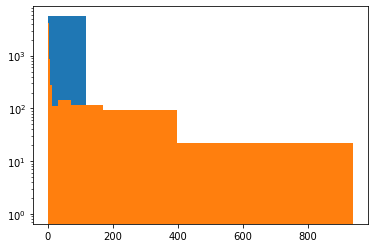

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# tracer un histogramme logarithmique
y = pd.Series(list_number_transactions)
hist, bins, _ = plt.hist(y, bins=8)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.yscale('log', nonposy='clip')
plt.hist(y, bins=logbins)
plt.show()

### récupérer la liste des utilisateurs qui pourraient etre problématiques

In [151]:
### selon l'histogramme on a environs une vingtaine d'utilisateurs qui ont effectué entre 400 et plus de 800 transactions
# on peut essayer de récupérer la liste de ces utilisateurs et étudier leurs comportements
# sauvegarder sur le disque la liste des utilisateurs ayant plus de 400 transactions
liste_utilisateurs_problematiques = []
for one_df_diff_ts in tqdm(list_df_with_diff_ts):
  if one_df_diff_ts.shape[0] >= 400:
    liste_utilisateurs_problematiques.append(one_df_diff_ts)

100%|██████████| 5763/5763 [00:00<00:00, 224571.69it/s]


In [ ]:
len(liste_utilisateurs_problematiques)

In [ ]:
liste_utilisateurs_problematiques[1]

In [179]:
def check_row_notnull(df):
  mask = df.notnull()
    
  # using dropna() method to drop NaN 
  # value rows
  df = df.where(mask).dropna()
  return df
  

### sauvegarder ces utilisateurs dans le disque en local

In [152]:
for elem in tqdm(liste_utilisateurs_problematiques):
  phone = elem['Phone_Number'][0]
  elem.to_csv(f'/content/drive/MyDrive/datasets/final/users_problematics/{phone}.csv', index=None)

100%|██████████| 22/22 [00:01<00:00, 20.81it/s]


### Création des times series

In [195]:
all_df_res = []
new_endpoint_col = []
for new_data_frame in tqdm(liste_utilisateurs_problematiques):
  new_data_frame['EndPoint'].fillna('', inplace=True) # modifie la colonne

  new_data_frame['Appplication_get'] = new_data_frame['EndPoint'].str.contains('applications/get').astype(np.float).astype('Int32')
  new_data_frame['Payment'] = new_data_frame['EndPoint'].str.contains('payment').astype(np.float).astype('Int32')
  new_data_frame['Declined'] = new_data_frame['EndPoint'].str.contains('decline').astype(np.float).astype('Int32')
  new_data_frame['Preapprouved'] = new_data_frame['EndPoint'].str.contains('preapproved').astype(np.float).astype('Int32')
  new_data_frame['Accepted'] = new_data_frame['EndPoint'].str.contains('accept').astype(np.float).astype('Int32')
  new_data_frame['Lifestyle'] = new_data_frame['EndPoint'].str.contains('lifestyle').astype(np.float).astype('Int32')
  new_data_frame['Wallet_balance'] = new_data_frame['EndPoint'].str.contains('wallet/balance').astype(np.float).astype('Int32')
  new_data_frame['Adverts'] = new_data_frame['EndPoint'].str.contains('adverts').astype(np.float).astype('Int32')
  new_data_frame['Bank'] = new_data_frame['EndPoint'].str.contains('bank').astype(np.float).astype('Int32')
  new_data_frame['Updated'] = new_data_frame['EndPoint'].str.contains('update').astype(np.float).astype('Int32')
  new_data_frame['Products'] = new_data_frame['EndPoint'].str.contains('products').astype(np.float).astype('Int32')
  new_data_frame['Locations'] = new_data_frame['EndPoint'].str.contains('locations').astype(np.float).astype('Int32')
  new_data_frame['Client_Get'] = new_data_frame['EndPoint'].str.contains('client/get').astype(np.float).astype('Int32')
  new_data_frame['Client_V2_Create'] = new_data_frame['EndPoint'].str.contains('client/v2/create').astype(np.float).astype('Int32')
  
  
  new_data_frame['Dummy'] = 0
  new_data_frame['Payment_cumulative'] = new_data_frame.groupby(['Dummy'])['Payment'].cumsum()
  new_data_frame['Decline_cumulative'] = new_data_frame.groupby(['Dummy'])['Declined'].cumsum()
  new_data_frame['Application_get_cumulative'] = new_data_frame.groupby(['Dummy'])['Appplication_get'].cumsum()
  new_data_frame['Preapprouved_cumulative'] = new_data_frame.groupby(['Dummy'])['Preapprouved'].cumsum()
  new_data_frame['Accepted_cumulative'] = new_data_frame.groupby(['Dummy'])['Accepted'].cumsum()
  new_data_frame['Lifestyle_cumulative'] = new_data_frame.groupby(['Dummy'])['Lifestyle'].cumsum()
  new_data_frame['Wallet_balance_cumulative'] = new_data_frame.groupby(['Dummy'])['Wallet_balance'].cumsum()
  new_data_frame['Adverts_cumulative'] = new_data_frame.groupby(['Dummy'])['Adverts'].cumsum()
  new_data_frame['Bank_cumulative'] = new_data_frame.groupby(['Dummy'])['Bank'].cumsum()
  new_data_frame['Update_cumulative'] = new_data_frame.groupby(['Dummy'])['Updated'].cumsum()
  new_data_frame['Products_cumulative'] = new_data_frame.groupby(['Dummy'])['Products'].cumsum()
  new_data_frame['Locations_cumulative'] = new_data_frame.groupby(['Dummy'])['Locations'].cumsum()
  new_data_frame['Client_Get_cumulative'] = new_data_frame.groupby(['Dummy'])['Client_Get'].cumsum()
  new_data_frame['Client_Get_cumulative'] = new_data_frame.groupby(['Dummy'])['Client_V2_Create'].cumsum()
  all_df_res.append(new_data_frame)
        

100%|██████████| 22/22 [00:00<00:00, 22.36it/s]


In [ ]:
all_df_res[1]